# import

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_excel('datafix_watermeter.xlsx', dtype={"nsb": str})
df = df.dropna(axis=1, how="all")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,nsb,periode,pakai
0,0104433255,201504,0
1,0104433255,201505,0
2,0104433255,201506,0
3,0104433255,201507,0
4,0104433255,201508,0


# eda

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5393 entries, 0 to 5392
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nsb      5393 non-null   object
 1   periode  5393 non-null   int64 
 2   pakai    5393 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 126.5+ KB


In [4]:
print(df['periode'].min())
print(df['periode'].max())

201504
202504


In [5]:
duplicated_rows = df[df.duplicated(keep=False)]
duplicated_rows

,nsb,periode,pakai
33,0104433255,201801,2
34,0104433255,201801,2
35,0104433255,201802,0
36,0104433255,201802,0
37,0104433255,201803,0
...,...,...,...
5312,0104434133,201810,5
5313,0104434133,201811,4
5314,0104434133,201811,4
5315,0104434133,201812,4


In [6]:
df = df.drop_duplicates(keep=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4405 entries, 0 to 5392
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nsb      4405 non-null   object
 1   periode  4405 non-null   int64 
 2   pakai    4405 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 137.7+ KB


In [7]:
# df['periode'] = pd.to_datetime(df['periode'])

# # --- 1. Boxplot of 'pakai' (overall or per 'nsb') ---
# plt.figure(figsize=(10, 5))
# sns.boxplot(x=df['pakai'])
# plt.title("Boxplot of 'pakai'")
# plt.show()

In [8]:
# plt.figure(figsize=(10, 5))
# sns.histplot(df['pakai'], bins=30, kde=True, color='skyblue', edgecolor='black')
# plt.title("Histogram of 'pakai'")
# plt.xlabel("Pakai")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# prepro

In [9]:
# df.info()

In [10]:
# Compute IQR
Q1 = df['pakai'].quantile(0.25)
Q3 = df['pakai'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['pakai'] >= lower_bound) & (df['pakai'] <= upper_bound)]


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4370 entries, 0 to 5392
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nsb      4370 non-null   object
 1   periode  4370 non-null   int64 
 2   pakai    4370 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 136.6+ KB


In [12]:
# plt.figure(figsize=(10, 5))
# sns.histplot(df['pakai'], bins=30, kde=True, color='skyblue', edgecolor='black')
# plt.title("Histogram of 'pakai'")
# plt.xlabel("Pakai")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [13]:
df = df.sort_values(['nsb', 'periode'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4370 entries, 0 to 5392
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nsb      4370 non-null   object
 1   periode  4370 non-null   int64 
 2   pakai    4370 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 136.6+ KB


In [14]:
df.head()

,nsb,periode,pakai
0,0104433255,201504,0
1,0104433255,201505,0
2,0104433255,201506,0
3,0104433255,201507,0
4,0104433255,201508,0


In [15]:
# Prepare empty lists to collect results
decomp_results = []

# Loop through each customer
for customer_id, group in df.groupby('nsb'):
    group = group.set_index('periode').sort_index()
    if len(group) >= 24:  # STL needs enough data points (at least 2 periods)
        stl = STL(group['pakai'], period=12)
        result = stl.fit()
        temp = group.copy()
        temp['trend'] = result.trend
        temp['seasonal'] = result.seasonal
        temp['resid'] = result.resid
        temp['nsb'] = customer_id
        decomp_results.append(temp.reset_index())
    # else: skip customers with too few data points

# Combine all results into a single DataFrame
df_decomp = pd.concat(decomp_results, ignore_index=True)

# Show the first few rows
df_decomp.head()

,periode,nsb,pakai,trend,seasonal,resid
0,201504,0104433255,0,1.219121,-1.269019,0.049898
1,201505,0104433255,0,1.453108,-1.665294,0.212186
2,201506,0104433255,0,1.681442,-2.485063,0.803621
3,201507,0104433255,0,1.902291,0.581016,-2.483307
4,201508,0104433255,0,2.113442,-1.978895,-0.134547


In [16]:
def split_train_test_by_last_years(df, test_years=2):
    train_list = []
    test_list = []
    
    max_periode = df['periode'].max()
    max_year = int(str(max_periode)[:4])
    
    # Test data start periode: January of (max_year - test_years + 1)
    test_start_year = max_year - test_years + 1
    test_start_periode = test_start_year * 100 + 1  # YYYY01
    
    for nsb, group in df.groupby('nsb'):
        group = group.sort_values('periode')
        
        train_df = group[group['periode'] < test_start_periode]
        test_df = group[group['periode'] >= test_start_periode]
        
        train_list.append(train_df)
        test_list.append(test_df)
        
    train_df = pd.concat(train_list, ignore_index=True)
    test_df = pd.concat(test_list, ignore_index=True)
    
    return train_df, test_df

# Contoh pemakaian untuk trend, seasonal, resid:
trend_df = df_decomp[['nsb', 'periode', 'trend']]
seasonal_df = df_decomp[['nsb', 'periode', 'seasonal']]
resid_df = df_decomp[['nsb', 'periode', 'resid']]

trend_train, trend_test = split_train_test_by_last_years(trend_df, test_years=2)
seasonal_train, seasonal_test = split_train_test_by_last_years(seasonal_df, test_years=2)
resid_train, resid_test = split_train_test_by_last_years(resid_df, test_years=2)

print("Trend train:", trend_train.shape, "Trend test:", trend_test.shape)
print("Seasonal train:", seasonal_train.shape, "Seasonal test:", seasonal_test.shape)
print("Resid train:", resid_train.shape, "Resid test:", resid_test.shape)


Trend train: (3747, 3) Trend test: (623, 3)
Seasonal train: (3747, 3) Seasonal test: (623, 3)
Resid train: (3747, 3) Resid test: (623, 3)


In [17]:
# Fungsi untuk normalisasi data per pelanggan (per NSB)
def normalize_per_customer(df, value_col):
    scaler_dict = {}
    norm_list = []
    for nsb, group in df.groupby('nsb'):
        scaler = MinMaxScaler()
        values = group[[value_col]].values
        norm_values = scaler.fit_transform(values)
        group[value_col + '_norm'] = norm_values
        scaler_dict[nsb] = scaler
        norm_list.append(group)
    norm_df = pd.concat(norm_list, ignore_index=True)
    return norm_df, scaler_dict

# Lakukan normalisasi ke semua komponen & simpan dengan nama *_norm
trend_train_norm, trend_scaler = normalize_per_customer(trend_train, 'trend')
trend_test_norm, _ = normalize_per_customer(trend_test, 'trend')

seasonal_train_norm, seasonal_scaler = normalize_per_customer(seasonal_train, 'seasonal')
seasonal_test_norm, _ = normalize_per_customer(seasonal_test, 'seasonal')

resid_train_norm, resid_scaler = normalize_per_customer(resid_train, 'resid')
resid_test_norm, _ = normalize_per_customer(resid_test, 'resid')

# Cek hasil normalisasi: bandingkan nilai asli dan nilai normalnya
print(trend_train_norm[['nsb', 'periode', 'trend', 'trend_norm']].head())

          nsb  periode     trend  trend_norm
0  0104433255   201504  1.219121    0.362180
1  0104433255   201505  1.453108    0.431534
2  0104433255   201506  1.681442    0.499213
3  0104433255   201507  1.902291    0.564674
4  0104433255   201508  2.113442    0.627260


# modelling

In [18]:
batch_size=32
seq_length=12
epochs=500

In [19]:
def mase_metric(y_test, y_pred):
    mae_model = np.mean(np.abs(y_test - y_pred))
    mae_naive = np.mean(np.abs(y_test[1:] - y_test[:-1]))
    return mae_model / mae_naive

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# def create_sequences(data, seq_length=12, value_col='trend'):
#     xs, ys = [], []
#     for nsb, group in data.groupby('nsb'):
#         group = group.sort_values('periode')
#         values = group[value_col].values
#         for i in range(len(values) - seq_length):
#             xs.append(values[i:i+seq_length])
#             ys.append(values[i+seq_length])
#     return np.array(xs), np.array(ys)

def create_sequences(data, seq_length=12, value_col='trend_norm'):
    xs, ys = [], []
    meta = []
    for nsb, group in data.groupby('nsb'):
        group = group.sort_values('periode')
        values = group[value_col].values
        for i in range(len(values) - seq_length):
            xs.append(values[i:i+seq_length])
            ys.append(values[i+seq_length])
            meta.append({
                'nsb': nsb,
                'periode': group['periode'].iloc[i + seq_length]
            })
    return np.array(xs), np.array(ys), pd.DataFrame(meta)

### trend

In [21]:
X_train_trend, y_train_trend, train_meta_trend = create_sequences(trend_train_norm, seq_length, 'trend_norm')
X_test_trend, y_test_trend, test_meta_trend = create_sequences(trend_test_norm, seq_length, 'trend_norm')

X_train_trend_tensor = torch.tensor(X_train_trend, dtype=torch.float32).unsqueeze(-1)
y_train_trend_tensor = torch.tensor(y_train_trend, dtype=torch.float32).unsqueeze(-1)
X_test_trend_tensor = torch.tensor(X_test_trend, dtype=torch.float32).unsqueeze(-1)
y_test_trend_tensor = torch.tensor(y_test_trend, dtype=torch.float32).unsqueeze(-1)

train_dataset_trend = TensorDataset(X_train_trend_tensor, y_train_trend_tensor)
train_loader_trend = DataLoader(train_dataset_trend, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/500, Train Loss: 0.1490, Test Loss: 0.2594
Epoch 2/500, Train Loss: 0.1177, Test Loss: 0.2106
Epoch 3/500, Train Loss: 0.0936, Test Loss: 0.1735
Epoch 4/500, Train Loss: 0.0783, Test Loss: 0.1547
Epoch 5/500, Train Loss: 0.0685, Test Loss: 0.1477
Epoch 6/500, Train Loss: 0.0593, Test Loss: 0.1454
Epoch 7/500, Train Loss: 0.0498, Test Loss: 0.1463
Epoch 8/500, Train Loss: 0.0406, Test Loss: 0.1504
Epoch 9/500, Train Loss: 0.0334, Test Loss: 0.1558
Epoch 10/500, Train Loss: 0.0291, Test Loss: 0.1587
Epoch 11/500, Train Loss: 0.0269, Test Loss: 0.1572
Epoch 12/500, Train Loss: 0.0255, Test Loss: 0.1527
Epoch 13/500, Train Loss: 0.0242, Test Loss: 0.1468
Epoch 14/500, Train Loss: 0.0230, Test Loss: 0.1400
Epoch 15/500, Train Loss: 0.0217, Test Loss: 0.1327
Epoch 16/500, Train Loss: 0.0204, Test Loss: 0.1248
Epoch 17/500, Train Loss: 0.0190, Test Loss: 0.1161
Epoch 18/500, Train Loss: 0.0176, Test Loss: 0.1066
Epoch 19/500, Train Loss: 0.0160, Test Loss: 0.0958
Epoch 20/500, Train L

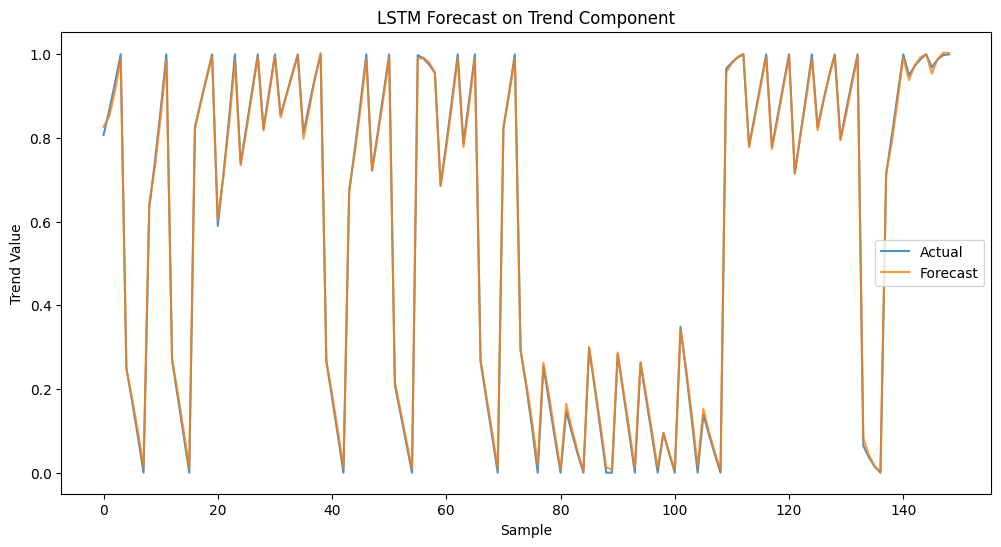

In [22]:
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader_trend:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_loss = np.mean(train_losses)
    
    # Eval on train set (optional) or small eval set to monitor
    model.eval()
    with torch.no_grad():
        output_test = model(X_test_trend_tensor.to(device))
        test_loss = criterion(output_test, y_test_trend_tensor.to(device)).item()
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Test Loss: {test_loss:.4f}")

# Forecast pada test set
model.eval()
with torch.no_grad():
    y_pred_trend = model(X_test_trend_tensor.to(device)).cpu().numpy()

# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test_trend, label='Actual', alpha=0.8)
plt.plot(y_pred_trend, label='Forecast', alpha=0.8)
plt.xlabel('Sample')
plt.ylabel('Trend Value')
plt.title('LSTM Forecast on Trend Component')
plt.legend()
plt.show()

In [23]:
start_idx = 0
y_true_orig_all = []
y_pred_orig_all = []

for nsb, group in test_meta_trend.groupby('nsb'):
    n = len(group)
    
    # Ambil subset normalisasi untuk nsb ini
    y_true_norm = y_test_trend[start_idx:start_idx + n].reshape(-1, 1)
    y_pred_norm = y_pred_trend[start_idx:start_idx + n].reshape(-1, 1)
    
    # Ambil scaler yang sesuai nsb (dari training)
    scaler = trend_scaler[nsb]
    
    # Inverse transform ke skala asli
    y_true_orig = scaler.inverse_transform(y_true_norm).flatten()
    y_pred_orig = scaler.inverse_transform(y_pred_norm).flatten()
    
    # Simpan hasilnya
    y_true_orig_all.append(y_true_orig)
    y_pred_orig_all.append(y_pred_orig)
    
    start_idx += n

# Gabungkan semua hasil inverse transform menjadi array 1D
y_true_orig_all = np.concatenate(y_true_orig_all)
y_pred_orig_all = np.concatenate(y_pred_orig_all)

# Hitung metrik evaluasi pada skala asli
r2 = r2_score(y_true_orig_all, y_pred_orig_all)
mae = mean_absolute_error(y_true_orig_all, y_pred_orig_all)
rmse = np.sqrt(mean_squared_error(y_true_orig_all, y_pred_orig_all))
mape = np.mean(np.abs((y_true_orig_all - y_pred_orig_all) / (y_true_orig_all + 1e-8))) * 100

print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R2 Score: 0.9996
MAE: 0.1491
RMSE: 0.2138
MAPE: 2705.04%


### seasonal

In [24]:
X_train_seasonal, y_train_seasonal, train_meta_seasonal = create_sequences(seasonal_train_norm, seq_length, 'seasonal_norm')
X_test_seasonal, y_test_seasonal, test_meta_seasonal= create_sequences(seasonal_test_norm, seq_length, 'seasonal_norm')

X_train_seasonal_tensor = torch.tensor(X_train_seasonal, dtype=torch.float32).unsqueeze(-1)
y_train_seasonal_tensor = torch.tensor(y_train_seasonal, dtype=torch.float32).unsqueeze(-1)
X_test_seasonal_tensor = torch.tensor(X_test_seasonal, dtype=torch.float32).unsqueeze(-1)
y_test_seasonal_tensor = torch.tensor(y_test_seasonal, dtype=torch.float32).unsqueeze(-1)

train_dataset_seasonal = TensorDataset(X_train_seasonal_tensor, y_train_seasonal_tensor)
train_loader_seasonal = DataLoader(train_dataset_seasonal, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/500, Train Loss: 0.1280, Test Loss: 0.1770
Epoch 2/500, Train Loss: 0.0773, Test Loss: 0.1290
Epoch 3/500, Train Loss: 0.0415, Test Loss: 0.1132
Epoch 4/500, Train Loss: 0.0377, Test Loss: 0.1130
Epoch 5/500, Train Loss: 0.0374, Test Loss: 0.1127
Epoch 6/500, Train Loss: 0.0372, Test Loss: 0.1121
Epoch 7/500, Train Loss: 0.0369, Test Loss: 0.1118
Epoch 8/500, Train Loss: 0.0365, Test Loss: 0.1115
Epoch 9/500, Train Loss: 0.0362, Test Loss: 0.1114
Epoch 10/500, Train Loss: 0.0359, Test Loss: 0.1107
Epoch 11/500, Train Loss: 0.0355, Test Loss: 0.1104
Epoch 12/500, Train Loss: 0.0350, Test Loss: 0.1099
Epoch 13/500, Train Loss: 0.0348, Test Loss: 0.1096
Epoch 14/500, Train Loss: 0.0343, Test Loss: 0.1090
Epoch 15/500, Train Loss: 0.0337, Test Loss: 0.1087
Epoch 16/500, Train Loss: 0.0335, Test Loss: 0.1088
Epoch 17/500, Train Loss: 0.0328, Test Loss: 0.1090
Epoch 18/500, Train Loss: 0.0323, Test Loss: 0.1081
Epoch 19/500, Train Loss: 0.0317, Test Loss: 0.1081
Epoch 20/500, Train L

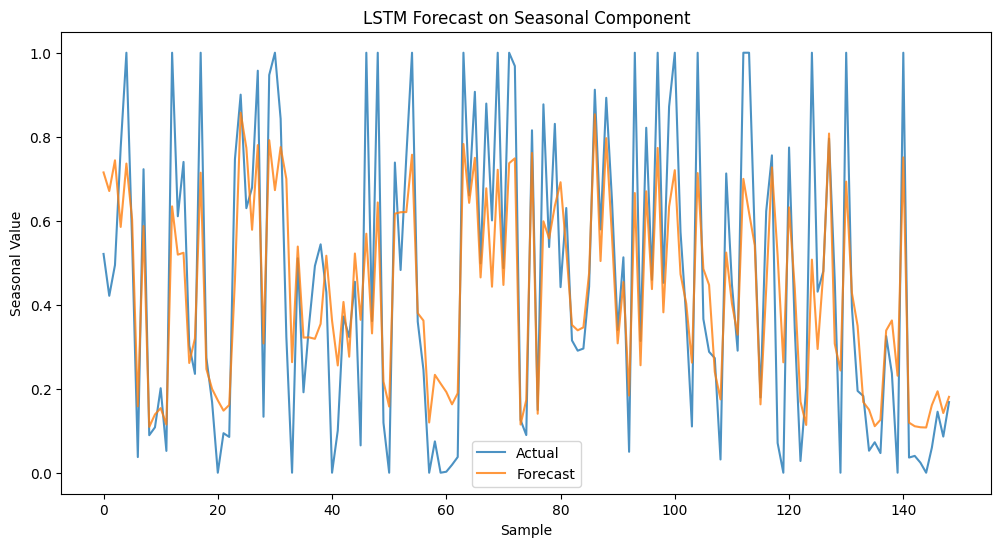

In [25]:
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader_seasonal:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_loss = np.mean(train_losses)
    
    # Eval on train set (optional) or small eval set to monitor
    model.eval()
    with torch.no_grad():
        output_test = model(X_test_seasonal_tensor.to(device))
        test_loss = criterion(output_test, y_test_seasonal_tensor.to(device)).item()
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Test Loss: {test_loss:.4f}")

# Forecast pada test set
model.eval()
with torch.no_grad():
    y_pred_seasonal = model(X_test_seasonal_tensor.to(device)).cpu().numpy()

# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test_seasonal, label='Actual', alpha=0.8)
plt.plot(y_pred_seasonal, label='Forecast', alpha=0.8)
plt.xlabel('Sample')
plt.ylabel('Seasonal Value')
plt.title('LSTM Forecast on Seasonal Component')
plt.legend()
plt.show()

In [26]:
start_idx = 0
y_true_orig_all = []
y_pred_orig_all = []

for nsb, group in test_meta_seasonal.groupby('nsb'):
    n = len(group)
    
    # Ambil subset normalisasi untuk nsb ini
    y_true_norm = y_test_seasonal[start_idx:start_idx + n].reshape(-1, 1)
    y_pred_norm = y_pred_seasonal[start_idx:start_idx + n].reshape(-1, 1)
    
    # Ambil scaler yang sesuai nsb (dari training)
    scaler = seasonal_scaler[nsb]
    
    # Inverse transform ke skala asli
    y_true_orig = scaler.inverse_transform(y_true_norm).flatten()
    y_pred_orig = scaler.inverse_transform(y_pred_norm).flatten()
    
    # Simpan hasilnya
    y_true_orig_all.append(y_true_orig)
    y_pred_orig_all.append(y_pred_orig)
    
    start_idx += n

# Gabungkan semua hasil inverse transform menjadi array 1D
y_true_orig_all = np.concatenate(y_true_orig_all)
y_pred_orig_all = np.concatenate(y_pred_orig_all)

# Hitung metrik evaluasi pada skala asli
r2 = r2_score(y_true_orig_all, y_pred_orig_all)
mae = mean_absolute_error(y_true_orig_all, y_pred_orig_all)
rmse = np.sqrt(mean_squared_error(y_true_orig_all, y_pred_orig_all))
mape = np.mean(np.abs((y_true_orig_all - y_pred_orig_all) / (y_true_orig_all + 1e-8))) * 100

print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R2 Score: 0.7677
MAE: 2.0909
RMSE: 2.9220
MAPE: 75.66%


### residual

In [27]:
X_train_resid, y_train_resid, train_meta_resid = create_sequences(resid_train_norm, seq_length, 'resid_norm')
X_test_resid, y_test_resid, test_meta_resid= create_sequences(resid_test_norm, seq_length, 'resid_norm')

X_train_resid_tensor = torch.tensor(X_train_resid, dtype=torch.float32).unsqueeze(-1)
y_train_resid_tensor = torch.tensor(y_train_resid, dtype=torch.float32).unsqueeze(-1)
X_test_resid_tensor = torch.tensor(X_test_resid, dtype=torch.float32).unsqueeze(-1)
y_test_resid_tensor = torch.tensor(y_test_resid, dtype=torch.float32).unsqueeze(-1)

train_dataset_resid = TensorDataset(X_train_resid_tensor, y_train_resid_tensor)
train_loader_resid = DataLoader(train_dataset_resid, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/500, Train Loss: 0.1209, Test Loss: 0.1820
Epoch 2/500, Train Loss: 0.0744, Test Loss: 0.1207
Epoch 3/500, Train Loss: 0.0394, Test Loss: 0.0856
Epoch 4/500, Train Loss: 0.0343, Test Loss: 0.0848
Epoch 5/500, Train Loss: 0.0341, Test Loss: 0.0831
Epoch 6/500, Train Loss: 0.0343, Test Loss: 0.0830
Epoch 7/500, Train Loss: 0.0339, Test Loss: 0.0830
Epoch 8/500, Train Loss: 0.0338, Test Loss: 0.0825
Epoch 9/500, Train Loss: 0.0336, Test Loss: 0.0815
Epoch 10/500, Train Loss: 0.0335, Test Loss: 0.0801
Epoch 11/500, Train Loss: 0.0333, Test Loss: 0.0792
Epoch 12/500, Train Loss: 0.0332, Test Loss: 0.0787
Epoch 13/500, Train Loss: 0.0330, Test Loss: 0.0780
Epoch 14/500, Train Loss: 0.0329, Test Loss: 0.0778
Epoch 15/500, Train Loss: 0.0329, Test Loss: 0.0767
Epoch 16/500, Train Loss: 0.0327, Test Loss: 0.0774
Epoch 17/500, Train Loss: 0.0326, Test Loss: 0.0746
Epoch 18/500, Train Loss: 0.0324, Test Loss: 0.0744
Epoch 19/500, Train Loss: 0.0321, Test Loss: 0.0733
Epoch 20/500, Train L

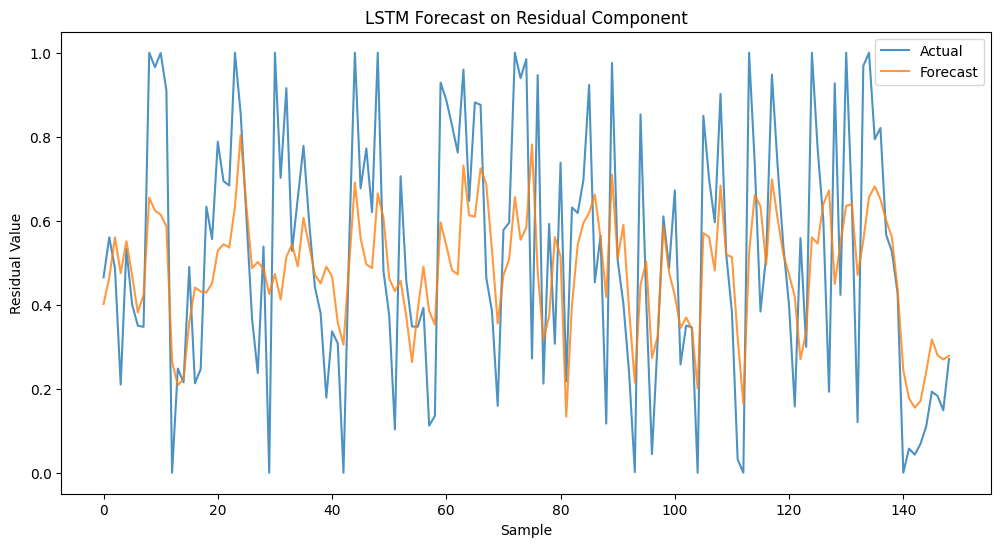

In [28]:
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader_resid:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_loss = np.mean(train_losses)
    
    # Eval on train set (optional) or small eval set to monitor
    model.eval()
    with torch.no_grad():
        output_test = model(X_test_resid_tensor.to(device))
        test_loss = criterion(output_test, y_test_resid_tensor.to(device)).item()
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Test Loss: {test_loss:.4f}")

# Forecast pada test set
model.eval()
with torch.no_grad():
    y_pred_resid = model(X_test_resid_tensor.to(device)).cpu().numpy()

# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test_resid, label='Actual', alpha=0.8)
plt.plot(y_pred_resid, label='Forecast', alpha=0.8)
plt.xlabel('Sample')
plt.ylabel('Residual Value')
plt.title('LSTM Forecast on Residual Component')
plt.legend()
plt.show()

In [29]:
start_idx = 0
y_true_orig_all = []
y_pred_orig_all = []

for nsb, group in test_meta_resid.groupby('nsb'):
    n = len(group)
    
    # Ambil subset normalisasi untuk nsb ini
    y_true_norm = y_test_resid[start_idx:start_idx + n].reshape(-1, 1)
    y_pred_norm = y_pred_resid[start_idx:start_idx + n].reshape(-1, 1)
    
    # Ambil scaler yang sesuai nsb (dari training)
    scaler = resid_scaler[nsb]
    
    # Inverse transform ke skala asli
    y_true_orig = scaler.inverse_transform(y_true_norm).flatten()
    y_pred_orig = scaler.inverse_transform(y_pred_norm).flatten()
    
    # Simpan hasilnya
    y_true_orig_all.append(y_true_orig)
    y_pred_orig_all.append(y_pred_orig)
    
    start_idx += n

# Gabungkan semua hasil inverse transform menjadi array 1D
y_true_orig_all = np.concatenate(y_true_orig_all)
y_pred_orig_all = np.concatenate(y_pred_orig_all)

# Hitung metrik evaluasi pada skala asli
r2 = r2_score(y_true_orig_all, y_pred_orig_all)
mae = mean_absolute_error(y_true_orig_all, y_pred_orig_all)
rmse = np.sqrt(mean_squared_error(y_true_orig_all, y_pred_orig_all))
mape = np.mean(np.abs((y_true_orig_all - y_pred_orig_all) / (y_true_orig_all + 1e-8))) * 100

print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R2 Score: 0.4421
MAE: 4.3899
RMSE: 5.8399
MAPE: 119.35%


### concat

In [31]:
start_idx_resid = 0
start_idx_trend = 0
start_idx_seasonal = 0

y_true_orig_all = []
y_pred_orig_all = []

for nsb, group in test_meta_resid.groupby('nsb'):
    n = len(group)
    
    # Residual inverse transform
    y_true_resid_norm = y_test_resid[start_idx_resid:start_idx_resid + n].reshape(-1, 1)
    y_pred_resid_norm = y_pred_resid[start_idx_resid:start_idx_resid + n].reshape(-1, 1)
    resid_scaler_obj = resid_scaler[nsb]
    y_true_resid_orig = resid_scaler_obj.inverse_transform(y_true_resid_norm).flatten()
    y_pred_resid_orig = resid_scaler_obj.inverse_transform(y_pred_resid_norm).flatten()
    
    # Trend inverse transform
    y_true_trend_norm = y_test_trend[start_idx_trend:start_idx_trend + n].reshape(-1, 1)
    y_pred_trend_norm = y_pred_trend[start_idx_trend:start_idx_trend + n].reshape(-1, 1)
    trend_scaler_obj = trend_scaler[nsb]
    y_true_trend_orig = trend_scaler_obj.inverse_transform(y_true_trend_norm).flatten()
    y_pred_trend_orig = trend_scaler_obj.inverse_transform(y_pred_trend_norm).flatten()
    
    # Seasonal inverse transform
    y_true_seasonal_norm = y_test_seasonal[start_idx_seasonal:start_idx_seasonal + n].reshape(-1, 1)
    y_pred_seasonal_norm = y_pred_seasonal[start_idx_seasonal:start_idx_seasonal + n].reshape(-1, 1)
    seasonal_scaler_obj = seasonal_scaler[nsb]
    y_true_seasonal_orig = seasonal_scaler_obj.inverse_transform(y_true_seasonal_norm).flatten()
    y_pred_seasonal_orig = seasonal_scaler_obj.inverse_transform(y_pred_seasonal_norm).flatten()
    
    # Gabungkan (jumlahkan) komponen untuk mendapatkan prediksi total
    y_true_orig = y_true_trend_orig + y_true_seasonal_orig + y_true_resid_orig
    y_pred_orig = y_pred_trend_orig + y_pred_seasonal_orig + y_pred_resid_orig
    
    y_true_orig_all.append(y_true_orig)
    y_pred_orig_all.append(y_pred_orig)
    
    start_idx_resid += n
    start_idx_trend += n
    start_idx_seasonal += n

# Gabungkan semua hasil inverse transform menjadi array 1D
y_true_orig_all = np.concatenate(y_true_orig_all)
y_pred_orig_all = np.concatenate(y_pred_orig_all)

# Hitung metrik evaluasi pada skala asli
r2 = r2_score(y_true_orig_all, y_pred_orig_all)
mae = mean_absolute_error(y_true_orig_all, y_pred_orig_all)
rmse = np.sqrt(mean_squared_error(y_true_orig_all, y_pred_orig_all))
mape = np.mean(np.abs((y_true_orig_all - y_pred_orig_all) / (y_true_orig_all + 1e-8))) * 100

print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


R2 Score: 0.8171
MAE: 4.7982
RMSE: 6.4302
MAPE: 62.15%
